### 区域舆情分析
分为几步：
1. 读取四个文件，包含所有评论的df，包含poi和评论数和坐标的df，地图的shp，还有四大区的shp
2. 通过join汇总每个大区不同类别的数量，并且根据poiid将大区结果返回评论总表
3. 得到有大区的评论总表可以进一步进行lda分析

#### 加载相应的package

In [15]:
# -*- coding: utf-8 -*-
import requests
import time
import os
import glob
import math
import ssl
import pandas as pd
import geopandas as gpd
from requests.adapters import HTTPAdapter
import json
import random
from concurrent.futures import ThreadPoolExecutor, as_completed
from snownlp import SnowNLP
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gaussian_kde
from shapely.geometry import Point

In [16]:
font_path="C:/Windows/Fonts/simhei.ttf"
plt.rcParams['font.sans-serif'] = ['SimHei']   # 设置默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False     # 解决负号显示问题

#### 读取相应的文件

In [18]:
def load_shp_files(folder_path):
    shp_files = glob.glob(os.path.join(folder_path, "*.shp"))
    gdf_dict = {}
    
    for shp_file in shp_files:
        try:
            gdf = gpd.read_file(shp_file)
            file_name = os.path.basename(shp_file)
            gdf_dict[file_name] = gdf
            
            print(f"✅ 成功加载: {file_name}")
            print(f"   要素数量: {len(gdf)}")
            print(f"   坐标系: {gdf.crs}")
            print(f"   边界范围: {gdf.total_bounds}")
            print(f"   属性字段: {list(gdf.columns)}")
            print("-" * 50)
            
        except Exception as e:
            print(f"❌ 加载失败: {os.path.basename(shp_file)} - 错误: {e}")
    
    return gdf_dict

In [ ]:
# 使用示例
folder_path = r"./data/七大区地理区划"  # Windows路径示例
gdf_dict = load_shp_files(folder_path)

✅ 成功加载: 东北地区.shp
   要素数量: 1
   坐标系: EPSG:4326
   边界范围: [118.83799744  38.72023392 135.08738708  53.55849838]
   属性字段: ['Id', 'geometry']
--------------------------------------------------
✅ 成功加载: 华东地区.shp
   要素数量: 1
   坐标系: PROJCS["China_Lambert_Conformal_Conic",GEOGCS["Beijing 1954",DATUM["Beijing_1954",SPHEROID["Krassowsky 1940",6378245,298.3,AUTHORITY["EPSG","7024"]],AUTHORITY["EPSG","6214"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",105],PARAMETER["standard_parallel_1",30],PARAMETER["standard_parallel_2",62],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
   边界范围: [ 852134.11825386 2960494.99634966 1746979.31228136 4698709.11293117]
   属性字段: ['name', 'geometry']
--------------------------------------------------
✅ 成功加载: 华中地区.shp
   要素数量: 1
   坐标系: PROJCS["China_Lambert

转化地理坐标的代码

In [20]:
target_crs = 'EPSG:4326'

for file_name, gdf in gdf_dict.items():
    print(f"🔄 处理文件: {file_name}")
    
    # 检查并转换坐标系
    if gdf.crs is not None and gdf.crs != target_crs:
        gdf_dict[file_name] = gdf.to_crs(target_crs)
        print(f" 已转换坐标系到: {target_crs}")
    else:
        print(f" 坐标系已是目标坐标系或无需转换")
    
    # 确保所有文件都有正确的坐标系
    gdf_dict[file_name].crs = target_crs

🔄 处理文件: 东北地区.shp
 坐标系已是目标坐标系或无需转换
🔄 处理文件: 华东地区.shp
 已转换坐标系到: EPSG:4326
🔄 处理文件: 华中地区.shp
 已转换坐标系到: EPSG:4326
🔄 处理文件: 华北地区.shp
 坐标系已是目标坐标系或无需转换
🔄 处理文件: 华南地区.shp
 已转换坐标系到: EPSG:4326
🔄 处理文件: 西北地区.shp
 坐标系已是目标坐标系或无需转换
🔄 处理文件: 西南地区.shp
 坐标系已是目标坐标系或无需转换


In [21]:
# 这个是添加列名
for file_name, gdf in gdf_dict.items():
    region_name = os.path.splitext(file_name)[0]
    gdf_dict[file_name]['region'] = region_name
    print(f"文件 {file_name} 添加区域列: {region_name}")

文件 东北地区.shp 添加区域列: 东北地区
文件 华东地区.shp 添加区域列: 华东地区
文件 华中地区.shp 添加区域列: 华中地区
文件 华北地区.shp 添加区域列: 华北地区
文件 华南地区.shp 添加区域列: 华南地区
文件 西北地区.shp 添加区域列: 西北地区
文件 西南地区.shp 添加区域列: 西南地区


合并所有的文件

In [22]:
# 提取所有的GeoDataFrame到列表
all_gdfs = list(gdf_dict.values())
# 合并所有GeoDataFrame
combined_gdf = gpd.GeoDataFrame(pd.concat(all_gdfs, ignore_index=True))
# 确保合并后的数据有正确的坐标系
combined_gdf.crs = target_crs

print(f" 合并完成!")
print(f" 总要素数量: {len(combined_gdf)}")
print(f"  包含区域: {combined_gdf['region'].unique().tolist()}")

# 设置输出路径
output_geojson = "./data/地理七大区域划分.geojson"

# 保存为GeoJSON文件
combined_gdf.to_file(output_geojson, driver='GeoJSON', encoding='utf-8')

print(f" GeoJSON文件已保存: {output_geojson}")
print(f"文件大小: {os.path.getsize(output_geojson) / 1024 / 1024:.2f} MB")

 合并完成!
 总要素数量: 7
  包含区域: ['东北地区', '华东地区', '华中地区', '华北地区', '华南地区', '西北地区', '西南地区']
 GeoJSON文件已保存: ./data/地理七大区域划分.geojson
文件大小: 3.25 MB


In [23]:
# 读取文件夹中所有CSV/Excel文件并合并
folder_path = "./各区域的景点汇总"  # 修改为您的文件夹路径

# 获取所有数据文件
all_data = []
for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(folder_path, file))
        all_data.append(df)
    elif file.endswith(('.xlsx', '.xls')):
        df = pd.read_excel(os.path.join(folder_path, file))
        all_data.append(df)

# 合并所有表格
if all_data:
    poi_df = pd.concat(all_data, ignore_index=True)
else:
    print("❌ 未找到CSV或Excel文件")

In [24]:
poi_df.shape

(41840, 19)

In [25]:
poi_df.to_csv("./data/全国所有景点汇总.csv", index=False, encoding='utf-8-sig')

In [26]:
region_7 = gpd.read_file('./data/地理七大区域划分.geojson')
poi_df = pd.read_csv('./data/全国所有景点汇总.csv', encoding='utf-8-sig')

#### 坐标系之间转换的代码

In [27]:
PI = math.pi

# BD09 <=> GCJ02 转换参数
baiduFactor = (PI * 3000.0) / 180.0

# WGS84 <=> GCJ02 转换参数
a = 6378245.0
ee = 0.006693421622965823

def isInChinaBbox(lon, lat):
    """粗略检查坐标是否在中国范围内"""
    return lon >= 72.004 and lon <= 137.8347 and lat >= 0.8293 and lat <= 55.8271

def transformLat(x, y):
    """纬度转换"""
    ret = -100.0 + 2.0 * x + 3.0 * y + 0.2 * y * y + 0.1 * x * y + 0.2 * math.sqrt(abs(x))
    ret += ((20.0 * math.sin(6.0 * x * PI) + 20.0 * math.sin(2.0 * x * PI)) * 2.0) / 3.0
    ret += ((20.0 * math.sin(y * PI) + 40.0 * math.sin((y / 3.0) * PI)) * 2.0) / 3.0
    ret += ((160.0 * math.sin((y / 12.0) * PI) + 320.0 * math.sin((y * PI) / 30.0)) * 2.0) / 3.0
    return ret

def transformLon(x, y):
    """经度转换"""
    ret = 300.0 + x + 2.0 * y + 0.1 * x * x + 0.1 * x * y + 0.1 * math.sqrt(abs(x))
    ret += ((20.0 * math.sin(6.0 * x * PI) + 20.0 * math.sin(2.0 * x * PI)) * 2.0) / 3.0
    ret += ((20.0 * math.sin(x * PI) + 40.0 * math.sin((x / 3.0) * PI)) * 2.0) / 3.0
    ret += ((150.0 * math.sin((x / 12.0) * PI) + 300.0 * math.sin((x / 30.0) * PI)) * 2.0) / 3.0
    return ret

def delta(lon, lat):
    """计算坐标偏移量"""
    dLon = transformLon(lon - 105.0, lat - 35.0)
    dLat = transformLat(lon - 105.0, lat - 35.0)
    
    radLat = (lat / 180.0) * PI
    magic = math.sin(radLat)
    magic = 1.0 - ee * magic * magic
    
    sqrtMagic = math.sqrt(magic)
    d_lon = (dLon * 180.0) / (a / sqrtMagic * math.cos(radLat) * PI)
    d_lat = (dLat * 180.0) / ((a * (1.0 - ee)) / (magic * sqrtMagic) * PI)
    
    return d_lon, d_lat

def WGS84ToGCJ02(lon_WGS, lat_WGS):
    """WGS84 转 GCJ02（火星坐标系）"""
    if not isInChinaBbox(lon_WGS, lat_WGS):
        return lon_WGS, lat_WGS
    
    d_lon, d_lat = delta(lon_WGS, lat_WGS)
    return lon_WGS + d_lon, lat_WGS + d_lat

def GCJ02ToWGS84(lon_GCJ, lat_GCJ):
    """GCJ02（火星坐标系）转 WGS84"""
    if not isInChinaBbox(lon_GCJ, lat_GCJ):
        return lon_GCJ, lat_GCJ
    
    # 迭代法求解
    wgs_lon, wgs_lat = lon_GCJ, lat_GCJ
    temp_lon, temp_lat = WGS84ToGCJ02(wgs_lon, wgs_lat)
    dx = temp_lon - lon_GCJ
    dy = temp_lat - lat_GCJ
    
    while abs(dx) > 1e-6 or abs(dy) > 1e-6:
        wgs_lon -= dx
        wgs_lat -= dy
        temp_lon, temp_lat = WGS84ToGCJ02(wgs_lon, wgs_lat)
        dx = temp_lon - lon_GCJ
        dy = temp_lat - lat_GCJ
    
    return wgs_lon, wgs_lat

def BD09ToGCJ02(lon_BD, lat_BD):
    """BD09（百度坐标系）转 GCJ02（火星坐标系）"""
    x = lon_BD - 0.0065
    y = lat_BD - 0.006
    z = math.sqrt(x * x + y * y) - 0.00002 * math.sin(y * baiduFactor)
    theta = math.atan2(y, x) - 0.000003 * math.cos(x * baiduFactor)
    gcj_lon = z * math.cos(theta)
    gcj_lat = z * math.sin(theta)
    return gcj_lon, gcj_lat

def GCJ02ToBD09(lon_GCJ, lat_GCJ):
    """GCJ02（火星坐标系）转 BD09（百度坐标系）"""
    z = math.sqrt(lon_GCJ * lon_GCJ + lat_GCJ * lat_GCJ) + 0.00002 * math.sin(lat_GCJ * baiduFactor)
    theta = math.atan2(lat_GCJ, lon_GCJ) + 0.000003 * math.cos(lon_GCJ * baiduFactor)
    bd_lon = z * math.cos(theta) + 0.0065
    bd_lat = z * math.sin(theta) + 0.006
    return bd_lon, bd_lat

def BD09ToWGS84(lon_BD, lat_BD):
    """BD09（百度坐标系）转 WGS84"""
    gcj_lon, gcj_lat = BD09ToGCJ02(lon_BD, lat_BD)
    return GCJ02ToWGS84(gcj_lon, gcj_lat)

def WGS84ToBD09(lon_WGS, lat_WGS):
    """WGS84 转 BD09（百度坐标系）"""
    gcj_lon, gcj_lat = WGS84ToGCJ02(lon_WGS, lat_WGS)
    return GCJ02ToBD09(gcj_lon, gcj_lat)

In [28]:
# 测试代码
if __name__ == "__main__":
    lon = 110.759817
    lat = 19.620011

    # 测试 BD09 转 WGS84
    wgs_lon, wgs_lat = BD09ToWGS84(lon, lat)
    print(f"BD09转WGS84: {wgs_lon:.10f}, {wgs_lat:.10f}")
    
    # 验证转换精度
    print(f"转换精度验证 - 经度误差: {abs(wgs_lon - lon):.10f}, 纬度误差: {abs(wgs_lat - lat):.10f}")

BD09转WGS84: 110.7489207213, 19.6155343761
转换精度验证 - 经度误差: 0.0108962787, 纬度误差: 0.0044766239


In [29]:
# 原来的代码：
geometry = [Point(xy) for xy in zip(poi_df["经度"], poi_df["纬度"])]
# 替换为：
# 先转换坐标，再创建几何对象
wgs84_coords = [BD09ToWGS84(lon, lat) for lon, lat in zip(poi_df["经度"], poi_df["纬度"])]
geometry = [Point(xy) for xy in wgs84_coords]
gdf = gpd.GeoDataFrame(poi_df, geometry=geometry, crs="EPSG:4326")
# 指定UTF-8编码以确保中文正确显示
gdf.to_file("./data/景区舆情分析.geojson", driver='GeoJSON', encoding='utf-8') ###这里输出了
print("所有坐标已完成BD09到WGS84转换！")

所有坐标已完成BD09到WGS84转换！


In [ ]:
gdf.head(10)

In [ ]:
# 检查每个景点ID对应的 geometry 是否唯一
dups = gdf.groupby('景点ID')['geometry'].nunique()

# 打印出 geometry 数量 > 1 的景点
dup_ids = dups[dups > 1]
print(f"共有 {len(dup_ids)} 个景点ID 对应多个 geometry")

if len(dup_ids) > 0:
    print(gdf[gdf['景点ID'].isin(dup_ids.index)].sort_values('景点ID').head())

共有 1 个景点ID 对应多个 geometry
          大类 子类关键词      景点ID    名称   评分  评论数       区域  城市            地址  \
12524  励志拓展型    大学  10520736  澳门大学  4.6  137  长隆旅游度假区  澳门  澳门 · 长隆旅游度假区   
41830  励志拓展型    大学  10520736  澳门大学  4.6  137  长隆旅游度假区  澳门       长隆旅游度假区   

                   分类   等级       特色   标签 门票说明 是否免费  \
12524  珠海必打卡景点榜 No.20  NaN  公立综合性大学  NaN   免费    是   
41830  珠海必打卡景点榜 No.20  NaN  公立综合性大学  NaN   免费    是   

                                                    图片链接  \
12524  https://dimg04.c-ctrip.com/images/0106x12000j7...   
41830  https://dimg04.c-ctrip.com/images/0106x12000j7...   

                                                    详情链接         纬度  \
12524  https://you.ctrip.com/sight/macau39/144805.htm...  22.134919   
41830  https://you.ctrip.com/sight/macau39/144805.htm...  22.136087   

               经度                   geometry  
12524  113.549206  POINT (113.5376 22.13169)  
41830  113.552307  POINT (113.5407 22.13292)  


In [33]:
gdf_unique = gdf.drop_duplicates(subset='景点ID', keep='first')

In [35]:
gdf_unique.to_file("./data/景区舆情分析.geojson", driver='GeoJSON', encoding='utf-8') ###这里输出了

In [62]:
import numpy as np
gdf = gpd.read_file('./data/景区舆情分析.geojson')
# 转换到米制投影（便于做 KDE, 比如中国用 EPSG:3857）
gdf = gdf.to_crs(epsg=3857)

#### 绘制一个舆情的热度图

In [38]:
cmap_colors = ["#1a5fb4", "#4a8fd6", "#2b6cb0", "#0d47a1", "#8ab4f7"]

In [39]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib.lines as mlines

def plot_heatmap_simple(geojson_path):
    """
    简单热力图可视化（带点大小图例）
    """
    gdf = gpd.read_file(geojson_path)
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    
    # 如果有权重字段
    if '评论数' in gdf.columns:
        # 按评论数升序排列，让小值在上层
        gdf = gdf.sort_values(by='评论数', ascending=True)

        weights = gdf['评论数']
        sizes = np.sqrt(weights) * 5  # 调整缩放因子

        # 自定义蓝色渐变色
        cmap_colors = ["#4a8fd6", "#2b6cb0", "#0d47a1"]
        cmap = LinearSegmentedColormap.from_list("custom_blue", cmap_colors, N=256)
        norm = Normalize(vmin=weights.min(), vmax=weights.max())
        colors = [cmap(norm(w)) for w in weights]

        # 绘制点（无边框）
        gdf.plot(
            ax=ax,
            color=colors,
            markersize=sizes,
            alpha=0.6,
            edgecolor='none'
        )

        # ===== 添加点大小图例 =====
        # 选几个代表性的评论数
        legend_sizes = np.percentile(weights, [10, 90, 95, 98])
        legend_labels = [f"{int(s)}" for s in legend_sizes]
        legend_markers = [plt.scatter([], [], s=np.sqrt(s)*5, color='#2b6cb0', alpha=0.6) for s in legend_sizes]

        legend = ax.legend(
            legend_markers,
            legend_labels,
            scatterpoints=1,
            frameon=False,
            labelspacing=1,
            title="评论数",
            loc='upper right'
        )
        plt.setp(legend.get_title(), fontsize=12)

    else:
        gdf.plot(ax=ax, markersize=10, alpha=0.6, color='blue', edgecolor='none')
    
    ax.set_title('研学评论分布热力图', fontsize=16)
    ax.set_xlabel('经度')
    ax.set_ylabel('纬度')
    
    plt.tight_layout()
    plt.savefig('E:/internship/ctrip/coding/data/heatmap_plot.png', dpi=300, bbox_inches='tight')
    plt.show()


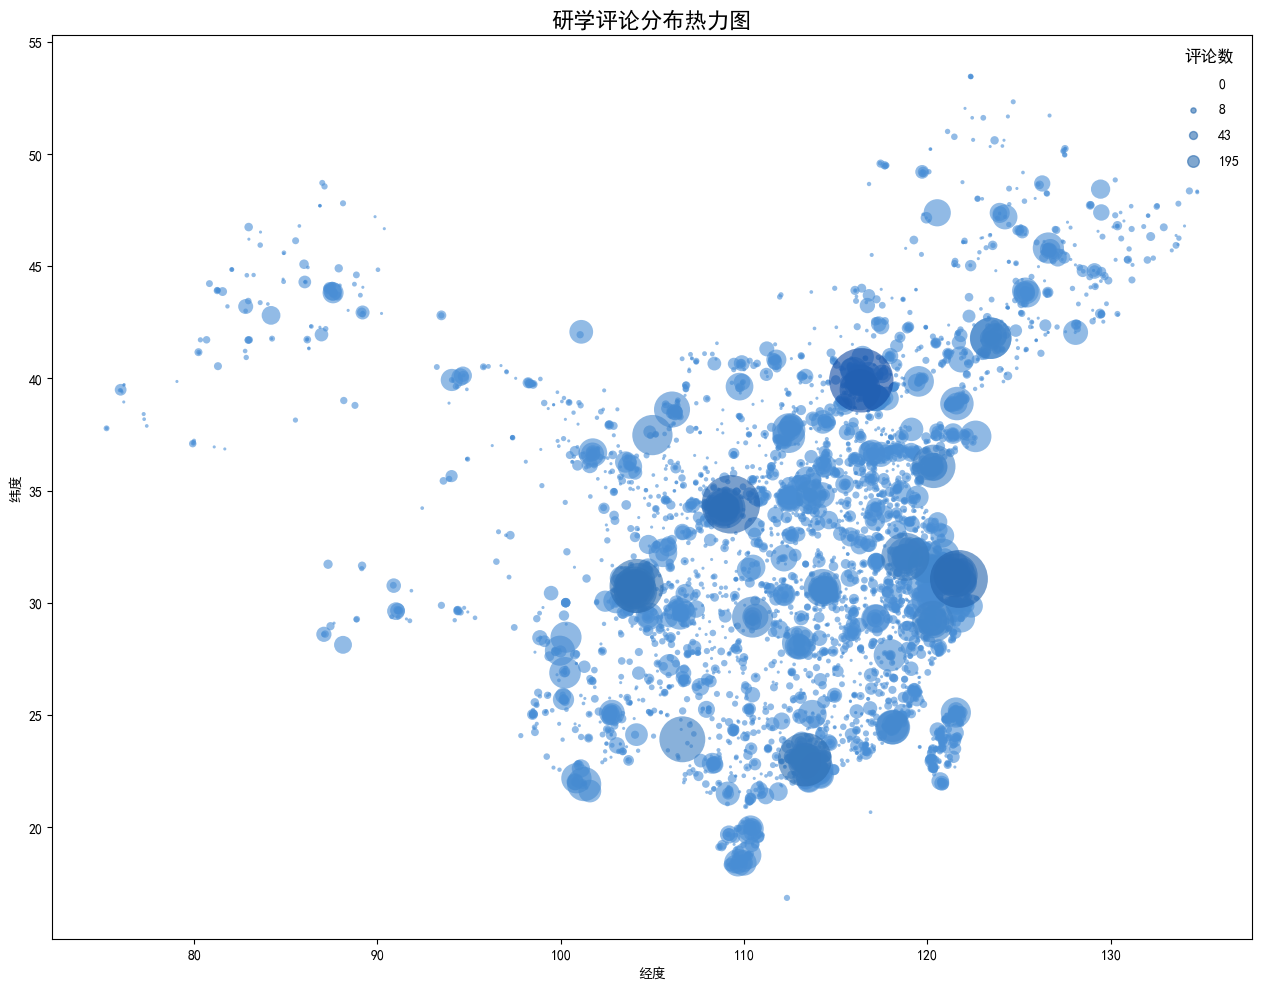

In [35]:
plot_heatmap_simple("./data/景区舆情分析.geojson")

#### 把景区加上区域属性

In [63]:
region_7  = region_7 .to_crs(epsg=3857)
poi_point = gdf.to_crs(epsg=3857)

In [64]:
# 空间连接：让每个点找到所在的面
poi_with_region = gpd.sjoin(
    poi_point, 
    region_7[['region', 'geometry']],  # 只保留关心的字段
    how='left',                        # 若点不在任何面内则为空
    predicate='within'                 # 判断点是否在面内
)

# 输出结果预览
print(poi_with_region.head())

      大类 子类关键词       景点ID           名称   评分  评论数               区域  城市  \
0  知识科普型   博物馆      88312       海南省博物馆  4.8  968  省政府/市中心/日月广场免税店  海口   
1  知识科普型   博物馆   56093155  中国（海南）南海博物馆  4.8   61             None  琼海   
2  知识科普型   博物馆   30072150       泰迪熊博物馆  4.1  329    美兰机场/观澜湖/江东新区  海口   
3  知识科普型   博物馆  143175085      海南疍家博物馆  5.0    2             None  陵水   
4  知识科普型   博物馆  129377879      海花岛博物馆群  4.7  296              海花岛  儋州   

                     地址                    分类  ...           标签 门票说明 是否免费  \
0  海口 · 省政府/市中心/日月广场免税店         海南亲子景点榜 No.12  ...  博物馆, 博物馆&展馆   免费    是   
1                    琼海          琼海亲子景点榜 No.3  ...  博物馆, 博物馆&展馆   免费    是   
2    海口 · 美兰机场/观澜湖/江东新区  海口观澜湖旅游度假区亲子景点榜 No.2  ...  展馆展览, 遛娃宝藏地   门票    否   
3                    陵水                  None  ...  博物馆, 博物馆&展馆   免费    是   
4              儋州 · 海花岛                  None  ...  博物馆, 博物馆&展馆   门票    否   

                                                图片链接  \
0  https://dimg04.c-ctrip.com/images/0101d

In [65]:
dups = poi_with_region.groupby('景点ID')['region'].nunique()

# 打印出 geometry 数量 > 1 的景点
dup_ids = dups[dups > 1]
print(f"共有 {len(dup_ids)} 个景点ID 对应多个 region")

if len(dup_ids) > 0:
    print(poi_with_region[poi_with_region['景点ID'].isin(dup_ids.index)].sort_values('景点ID').head())

共有 11 个景点ID 对应多个 region
          大类  子类关键词      景点ID           名称   评分  评论数    区域  城市  地址    分类  ...  \
37974  自然观赏型  自然保护区     82308  阴条岭国家级自然保护区  0.0    0  None  巫山  巫山  None  ...   
37974  自然观赏型  自然保护区     82308  阴条岭国家级自然保护区  0.0    0  None  巫山  巫山  None  ...   
17470  知识科普型    博物馆  51717911  太行山大峡谷地质博物馆  4.1    9  None  壶关  壶关  None  ...   
17470  知识科普型    博物馆  51717911  太行山大峡谷地质博物馆  4.1    9  None  壶关  壶关  None  ...   
18766  知识科普型    博物馆  79438970  潼关县秦王寨历史博物馆  3.0    1  None  潼关  潼关  None  ...   

                 标签  门票说明 是否免费  \
37974    登高爬山, 自然山水  None    否   
37974    登高爬山, 自然山水  None    否   
17470  自然山水, 博物馆&展馆  None    否   
17470  自然山水, 博物馆&展馆  None    否   
18766   博物馆, 博物馆&展馆    免费    是   

                                                    图片链接  \
37974  https://dimg04.c-ctrip.com/images/0105a120008o...   
37974  https://dimg04.c-ctrip.com/images/0105a120008o...   
17470  https://dimg04.c-ctrip.com/images/01A6e1200094...   
17470  https://dimg04.c-ctrip.com/images/01A

In [66]:
import openpyxl
dups_table = poi_with_region[poi_with_region['景点ID'].isin(dup_ids.index)]
dups_table.to_excel('poi_region_conflicts.xlsx', index=False)

In [ ]:
# 读入人工修正表
manual_fix = pd.read_excel('poi_region_conflicts.xlsx')[['景点ID', 'correct_region']].dropna()

# 对每个景点ID保留正确的region
poi_with_region = poi_with_region.merge(
    manual_fix,
    on='景点ID',
    how='left'
)

# 如果有人工修正的，则只保留匹配correct_region的行；否则保留原始行
poi_with_region = poi_with_region[
    (poi_with_region['correct_region'].isna()) | 
    (poi_with_region['region'] == poi_with_region['correct_region'])
]

# 最后去掉辅助列
poi_with_region = poi_with_region.drop(columns='correct_region')


In [68]:
dups = poi_with_region.groupby('景点ID')['region'].nunique()

# 打印出 geometry 数量 > 1 的景点
dup_ids = dups[dups > 1]
print(f"共有 {len(dup_ids)} 个景点ID 对应多个 region")

共有 0 个景点ID 对应多个 region


In [70]:
poi_with_region.to_file("./data/区域景区统计.geojson", driver='GeoJSON', encoding='utf-8') 

##### 去重之后每个景区的数量统计和评论匹配

In [17]:
poi_with_region = gpd.read_file('./data/区域景区统计.geojson')

In [ ]:
poi_with_region[poi_with_region['region'].isna()].head(10)

In [73]:
summary = poi_with_region.groupby(['大类', 'region']).agg(
     相关景区数量=('景点ID', 'nunique')
).reset_index()

print("✅ 景区数量：")
print(summary)

✅ 景区数量：
       大类 region  相关景区数量
0   体验考察型   东北地区     102
1   体验考察型   华东地区     837
2   体验考察型   华中地区     378
3   体验考察型   华北地区     258
4   体验考察型   华南地区     502
5   体验考察型   西北地区     186
6   体验考察型   西南地区     356
7   励志拓展型   东北地区     685
8   励志拓展型   华东地区    3138
9   励志拓展型   华中地区    1020
10  励志拓展型   华北地区    1530
11  励志拓展型   华南地区    1026
12  励志拓展型   西北地区     720
13  励志拓展型   西南地区    1109
14  文化康乐型   东北地区      32
15  文化康乐型   华东地区     343
16  文化康乐型   华中地区      38
17  文化康乐型   华北地区     531
18  文化康乐型   华南地区      66
19  文化康乐型   西北地区     250
20  文化康乐型   西南地区     147
21  知识科普型   东北地区    1545
22  知识科普型   华东地区    9173
23  知识科普型   华中地区    2983
24  知识科普型   华北地区    3713
25  知识科普型   华南地区    2986
26  知识科普型   西北地区    1897
27  知识科普型   西南地区    3152
28  自然观赏型   东北地区     161
29  自然观赏型   华东地区     551
30  自然观赏型   华中地区     227
31  自然观赏型   华北地区     256
32  自然观赏型   华南地区     262
33  自然观赏型   西北地区     238
34  自然观赏型   西南地区     364


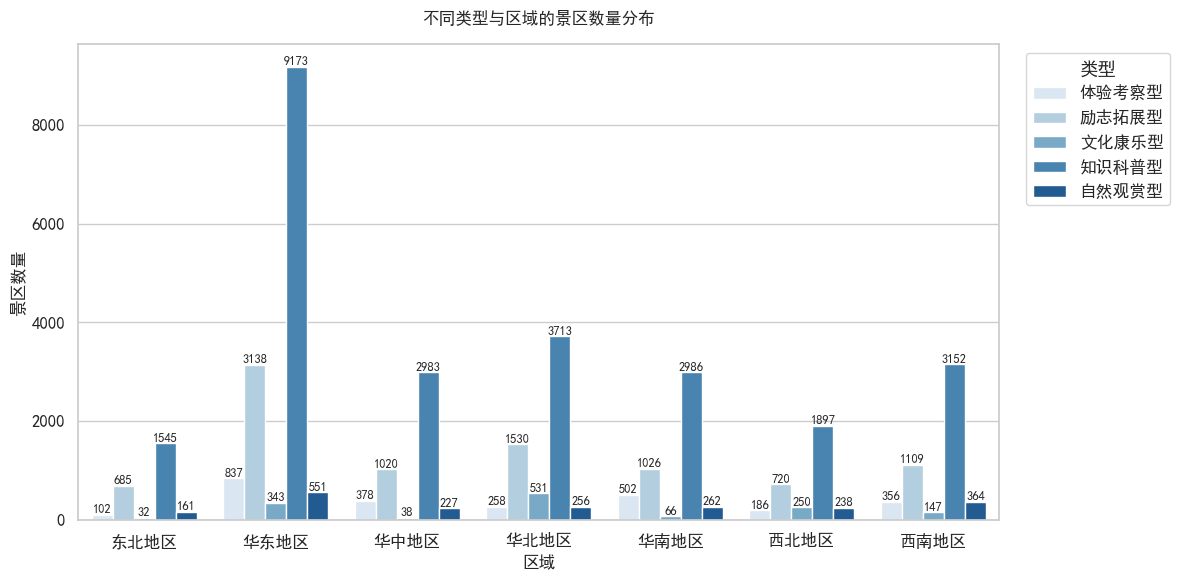

In [74]:
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid",font_scale=1.1)
font_path="C:/Windows/Fonts/simhei.ttf"
plt.rcParams['font.sans-serif'] = ['SimHei']   # 设置默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False     # 解决负号显示问题

# 绘制分组条形图
barplot = sns.barplot(
    data=summary,
    x='region', y='相关景区数量',
    hue='大类',
    palette='Blues'
)

# ✅ 添加中文数据标签
for container in barplot.containers:
    # 在每个柱子上方标注中文内容
    barplot.bar_label(
        container,
        labels=[f"{int(height)}" for height in container.datavalues],
        label_type='edge',
        fontsize=9
    )

# 旋转横轴标签防止重叠
plt.xticks(rotation=0, ha='center')

# 添加标题与轴标签（中文）
plt.title("不同类型与区域的景区数量分布", fontsize=12, pad=15)
plt.xlabel("区域", fontsize=12)
plt.ylabel("景区数量", fontsize=12)
plt.legend(title="类型", bbox_to_anchor=(1.02, 1), loc='upper left')

# ✅ 在图形中添加额外中文说明文字（可选）
plt.text(
    x=-0.5, y=max(summary['相关景区数量']) * 1.05,
    s="",
    fontsize=10, color='gray'
)

plt.tight_layout()
plt.show()

In [18]:
comments_df = pd.read_csv('df_all.csv', encoding='utf-8-sig')

C:\Users\lenovo\AppData\Local\Temp\ipykernel_38380\1204374322.py:1: DtypeWarning: Columns (12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  comments_df = pd.read_csv('df_all.csv', encoding='utf-8-sig')


In [20]:
comments_df = comments_df.drop_duplicates(subset="commentId", keep="first")

In [21]:
comments_df.shape

(1193541, 17)

In [22]:
poi_with_region = poi_with_region.drop_duplicates(subset='景点ID', keep='first')

In [23]:
comments_df = comments_df.merge(
    poi_with_region[['景点ID', 'region']],
    how='left',
    left_on='poi_id',
    right_on='景点ID'
)

In [24]:
comments_df.shape

(1193541, 19)

In [25]:
# 筛选 region 为 NaN 的记录
unmatched = comments_df[comments_df['region'].isna()]

# 按 city 聚合，统计未匹配的 poi_id 列表
city_poiid = unmatched.groupby('city')['poi_id'].apply(list).reset_index()

# 查看结果
print(city_poiid.head())

  city                                             poi_id
0   上海  [98617, 98617, 98617, 98617, 98617, 98617, 986...
1   台湾  [10523703, 10523703, 10523703, 10523703, 10523...
2   天津  [31668482, 31668482, 31668482, 31668482, 14862...
3   山东  [64264508, 64264508, 56810249, 56810249, 56810...
4   广东  [79467041, 79467041, 79467041, 79467041, 79467...


In [26]:
city_region_map = {
    '北京': '华北地区',
    '上海': '华东地区',
    '广东': '华南地区',
    '台湾':'华东地区',
    '天津':'华北地区',
    '山东':'华东地区',
    '广西':'华南地区',
    '江苏':'华东地区',
    '河南':'华中地区',
    '浙江':'华东地区',
    '海南':'华南地区',
    '澳门':'华南地区',
    '福建':'华东地区',
    '辽宁':'东北地区',
    '香港':'华南地区'
    # 其他 city -> region 映射
}

# 只填充 region 缺失的行
comments_df.loc[comments_df['region'].isna(), 'region'] = comments_df.loc[comments_df['region'].isna(), 'city'].map(city_region_map)

# 检查缺失情况
print(comments_df['region'].isna().sum())

0


In [28]:
comments_df.to_csv("./data/区域景区评论汇总.csv", index=False, encoding='utf-8-sig')

In [29]:
# 按类型 × 情感统计评论数量
summary = comments_df.groupby(['region']).agg(
    评论数=('content', 'count')
).reset_index()

print("✅ 每个大区的评论数量：")
print(summary)
#需要去除评论分数为0的评论

✅ 每个大区的评论数量：
  region     评论数
0   东北地区   71053
1   华东地区  415534
2   华中地区  139294
3   华北地区  140523
4   华南地区  128790
5   西北地区  109894
6   西南地区  188453


In [30]:
# 按类型 × 情感统计评论数量
summary = comments_df.groupby(['poi_type', 'region']).agg(
    评论数=('content', 'count')
).reset_index()

print("✅ 各类型好评/差评评论数量：")
print(summary)
#需要去除评论分数为0的评论

✅ 各类型好评/差评评论数量：
   poi_type region     评论数
0     体验考察型   东北地区      34
1     体验考察型   华东地区     875
2     体验考察型   华中地区     688
3     体验考察型   华北地区     895
4     体验考察型   华南地区    7418
5     体验考察型   西北地区      48
6     体验考察型   西南地区      35
7     励志拓展型   东北地区     262
8     励志拓展型   华东地区    6085
9     励志拓展型   华中地区    4728
10    励志拓展型   华北地区     804
11    励志拓展型   华南地区    5123
12    励志拓展型   西北地区     443
13    励志拓展型   西南地区     593
14    文化康乐型   东北地区    3786
15    文化康乐型   华东地区   57809
16    文化康乐型   华中地区    9306
17    文化康乐型   华北地区    2395
18    文化康乐型   华南地区    7871
19    文化康乐型   西北地区    9349
20    文化康乐型   西南地区    2771
21    知识科普型   东北地区   54563
22    知识科普型   华东地区  321052
23    知识科普型   华中地区   94367
24    知识科普型   华北地区  121042
25    知识科普型   华南地区   90384
26    知识科普型   西北地区   83961
27    知识科普型   西南地区  148358
28    自然观赏型   东北地区   12408
29    自然观赏型   华东地区   29713
30    自然观赏型   华中地区   30205
31    自然观赏型   华北地区   15387
32    自然观赏型   华南地区   17994
33    自然观赏型   西北地区   16093
34    自然观赏型   西南地区   36696


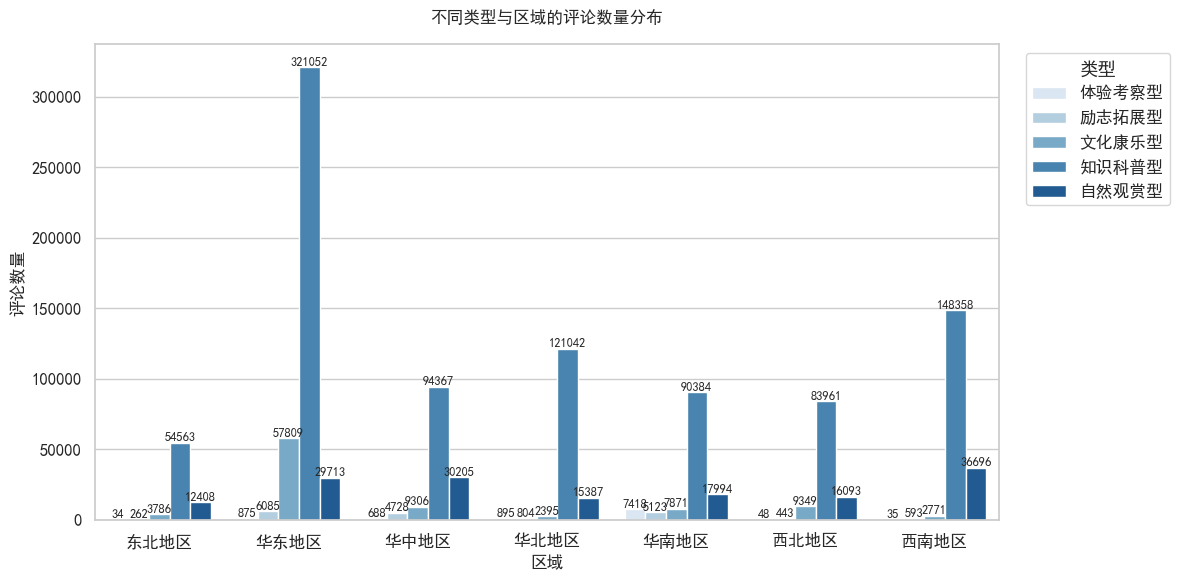

In [31]:
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid",font_scale=1.1)
font_path="C:/Windows/Fonts/simhei.ttf"
plt.rcParams['font.sans-serif'] = ['SimHei']   # 设置默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False     # 解决负号显示问题

# 绘制分组条形图
barplot = sns.barplot(
    data=summary,
    x='region', y='评论数',
    hue='poi_type',
    palette='Blues'
)

# ✅ 添加中文数据标签
for container in barplot.containers:
    # 在每个柱子上方标注中文内容
    barplot.bar_label(
        container,
        labels=[f"{int(height)}" for height in container.datavalues],
        label_type='edge',
        fontsize=9
    )

# 旋转横轴标签防止重叠
plt.xticks(rotation=0, ha='center')

# 添加标题与轴标签（中文）
plt.title("不同类型与区域的评论数量分布", fontsize=12, pad=15)
plt.xlabel("区域", fontsize=12)
plt.ylabel("评论数量", fontsize=12)
plt.legend(title="类型", bbox_to_anchor=(1.02, 1), loc='upper left')

# ✅ 在图形中添加额外中文说明文字（可选）
plt.text(
    x=-0.5, y=max(summary['评论数']) * 1.05,
    s="",
    fontsize=10, color='gray'
)

plt.tight_layout()
plt.show()

#### 华北的评论LDA提取

In [9]:
import jieba
import pandas as pd
import os
import glob
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import networkx as nx
from itertools import combinations
from collections import Counter
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import ListedColormap
import community

In [6]:
comments_df = pd.read_csv('./data/区域景区评论汇总.csv', encoding='utf-8-sig')

C:\Users\lenovo\AppData\Local\Temp\ipykernel_18628\3365735254.py:1: DtypeWarning: Columns (12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  comments_df = pd.read_csv('./data/区域景区评论汇总.csv', encoding='utf-8-sig')


In [94]:
huabei_comments = comments_df[comments_df['region'] == '华北地区']
print(huabei_comments.head())
print(f"华北评论数量: {len(huabei_comments)}")

        poi_id    poi_name poi_type poi_subtype  commentId  \
150116   95275  七星湖沙漠生态旅游区    自然观赏型        生态景区  164678856   
150117   95275  七星湖沙漠生态旅游区    自然观赏型        生态景区  164286177   
150118   95275  七星湖沙漠生态旅游区    自然观赏型        生态景区  163263336   
150119   95275  七星湖沙漠生态旅游区    自然观赏型        生态景区  168554105   
150120   95275  七星湖沙漠生态旅游区    自然观赏型        生态景区  166661190   

                                                  content  score  \
150116  可玩性低，景色一般，性价比低，体验不佳，开了近两百公里，被忽悠的买了套票，进去包含的项目之间...    3.0   
150117  适合自驾，每个项目距离较远，一定要有车！ 景区太大，一路开车都看不到工作人员，希望可以多些路...    4.0   
150118                     美丽的草原风光无限,自然而然,清新脱俗气质,旅游景点好去处！    5.0   
150119  在沙漠里有一片绿洲挺神奇的 我去的时候下暴雨 更神奇。属于周边主题度假型，有些馆没开挺遗憾。...    4.0   
150120                                现场门票要100，有点坑 可以开车进去    3.0   

       touristTypeDisplay timeDuration   publishTypeTag  sortType  \
150116               家庭亲子          NaN  2020-10-07 发布点评       NaN   
150117               其他出游          NaN  2020-08-30 发布点评       NaN   
150118     

In [95]:
# 按类型 × 情感统计评论数量
summary = huabei_comments.groupby(['poi_type']).agg(
    评论数=('content', 'count')
).reset_index()

print("✅ 各类型好评/差评评论数量：")
print(summary)
#需要去除评论分数为0的评论

✅ 各类型好评/差评评论数量：
  poi_type     评论数
0    体验考察型     895
1    励志拓展型     804
2    文化康乐型    2395
3    知识科普型  121042
4    自然观赏型   15387


#### 长文本构建lda

In [1]:
import jieba
import pandas as pd
import os
import glob
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import networkx as nx
from itertools import combinations
from collections import Counter
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import ListedColormap
import community

In [2]:
comments_df = pd.read_csv('./data/区域景区评论汇总.csv', encoding='utf-8-sig')

C:\Users\lenovo\AppData\Local\Temp\ipykernel_38380\3365735254.py:1: DtypeWarning: Columns (12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  comments_df = pd.read_csv('./data/区域景区评论汇总.csv', encoding='utf-8-sig')


In [3]:
comments_df["commentId"].duplicated().sum()

79

In [4]:
comments_df = comments_df.drop_duplicates(subset="commentId", keep="first")

In [5]:
# 分词的函数
def prepare_texts_basic(df, stopwords_path, min_sample=200, min_length=5):
    """
    基础文本处理：分词 + 停用词过滤 + 长度过滤
    """

    texts = df['content'].dropna().astype(str).tolist()

    # 加载停用词
    with open(stopwords_path, "r", encoding="utf-8") as f:
        stopwords = set(w.strip() for w in f if w.strip())

    # 分词 + 停用词过滤
    texts_cut = []
    for text in texts:
        words = [w for w in jieba.cut(text) if w not in stopwords and len(w) > 1 and not w.isdigit()]
        if len(words) >= min_length:
            texts_cut.append(words)

    print(f" 已完成分词与过滤，共 {len(texts_cut)} 条有效评论")
    return texts_cut

In [6]:
def filter_long_texts(texts_cut, min_len=5):
    """
    筛选出长度大于 min_len 的评论
    """
    texts_long = [doc for doc in texts_cut if len(doc) >= min_len]
    print(f"筛选完成，保留 {len(texts_long)} 条长评论（长度 >= {min_len}）")
    return texts_long

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
# gensim.models.LdaModel	sklearn.decomposition.LatentDirichletAllocation这两个模型选哪一种
def lda_from_long_texts(texts_long, n_topics=5, max_iter=10, random_state=42): #11
    # 合并分词为字符串
    docs_str = [" ".join(doc) for doc in texts_long]

    # 构建词频矩阵
    vectorizer = CountVectorizer()
    count_matrix = vectorizer.fit_transform(docs_str)
    feature_names = vectorizer.get_feature_names_out()

    # 训练 LDA
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        max_iter=max_iter,
        random_state=random_state
    )
    lda.fit(count_matrix)

    # 输出主题关键词
    topics = {}
    for i, topic in enumerate(lda.components_):
        top_words = [feature_names[j] for j in topic.argsort()[-10:][::-1]]
        topics[f'Topic {i+1}'] = top_words

    topics_df = pd.DataFrame(topics)
    return lda, count_matrix, topics_df

##### 华北地区

In [8]:
huabei_comments = comments_df[comments_df['region'] == '华北地区']

In [9]:
# Step 1: 基础分词
texts_basic_huabei = prepare_texts_basic(df= huabei_comments, stopwords_path='./trip_stopwords.txt')

Building prefix dict from the default dictionary ...


Loading model from cache C:\Users\lenovo\AppData\Local\Temp\jieba.cache
Loading model cost 0.671 seconds.
Prefix dict has been built successfully.


 已完成分词与过滤，共 78737 条有效评论


In [10]:
texts_long_huabei = filter_long_texts(texts_basic_huabei, min_len=20)

筛选完成，保留 20532 条长评论（长度 >= 20）


主题数=20, Perplexity=3139.73
主题数=21, Perplexity=3107.61
主题数=22, Perplexity=3056.07
主题数=23, Perplexity=3069.92
主题数=24, Perplexity=3058.21
主题数=25, Perplexity=3096.95
主题数=26, Perplexity=3076.63
主题数=27, Perplexity=3031.32
主题数=28, Perplexity=3033.50
主题数=29, Perplexity=3039.59


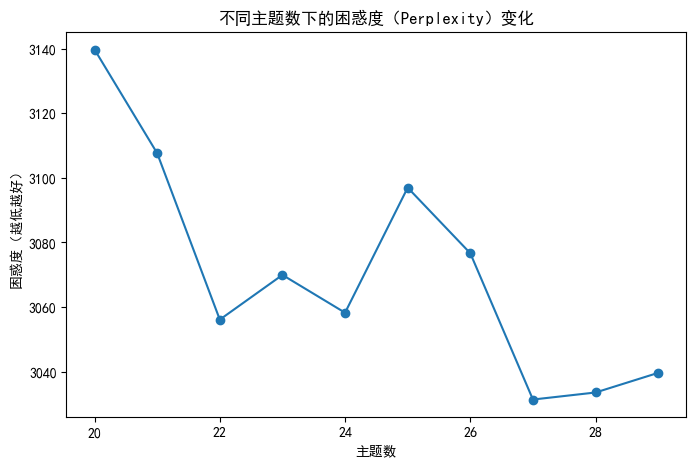

In [ ]:
# 困惑度检测找寻最佳主题数
docs = [" ".join(doc) for doc in texts_long_huabei]  # 你的分词结果
vectorizer = CountVectorizer(max_df=0.95, min_df=5)
count_data = vectorizer.fit_transform(docs)

perplexities = []
topic_nums = range(20, 30)

for n in topic_nums:
    lda = LatentDirichletAllocation(
        n_components=n,
        max_iter=10,
        learning_method='batch',
        random_state=16
    )
    lda.fit(count_data)
    perplexity = lda.perplexity(count_data)
    perplexities.append(perplexity)
    print(f"主题数={n}, Perplexity={perplexity:.2f}")

# 绘制结果
plt.figure(figsize=(8, 5))
plt.plot(topic_nums, perplexities, marker='o')
plt.title("不同主题数下的困惑度（Perplexity）变化")
plt.xlabel("主题数")
plt.ylabel("困惑度（越低越好）")
plt.show()

In [11]:
empty_count = sum(1 for t in texts_long_huabei if (t is None) or (not isinstance(t, list)) or (len(t) == 0))
print(f"空文本数量：{empty_count}")

空文本数量：0


In [12]:
lda_model_huabei, count_matrix_huabei, topics_df_huabei = lda_from_long_texts(texts_long_huabei, random_state=42, n_topics=28)

In [14]:
topics_df_huabei.to_csv("./data/华北总结.csv", index=False, encoding='utf-8-sig')

##### 华东地区

In [10]:
huadong_comments = comments_df[comments_df['region'] == '华东地区']

In [11]:
# Step 1: 基础分词
texts_basic_huadong = prepare_texts_basic(df= huadong_comments, stopwords_path='./trip_stopwords.txt')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\lenovo\AppData\Local\Temp\jieba.cache
Loading model cost 0.759 seconds.
Prefix dict has been built successfully.


 已完成分词与过滤，共 213900 条有效评论


In [12]:
texts_long_huadong = filter_long_texts(texts_basic_huadong, min_len=20)

筛选完成，保留 48091 条长评论（长度 >= 20）


主题数=25, Perplexity=3984.63
主题数=26, Perplexity=3948.13
主题数=27, Perplexity=3944.23
主题数=28, Perplexity=3921.37
主题数=29, Perplexity=3954.15
主题数=30, Perplexity=3967.14
主题数=31, Perplexity=3955.23
主题数=32, Perplexity=3986.84
主题数=33, Perplexity=3957.21
主题数=34, Perplexity=3938.03
主题数=35, Perplexity=3951.59


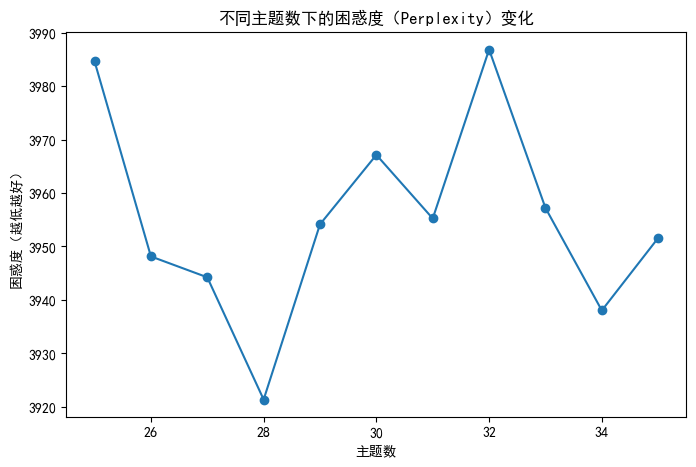

In [ ]:
# 困惑度检测找寻最佳主题数
docs = [" ".join(doc) for doc in texts_long_huadong]  # 你的分词结果
vectorizer = CountVectorizer(max_df=0.95, min_df=5)
count_data = vectorizer.fit_transform(docs)

perplexities = []
topic_nums = range(25, 36)

for n in topic_nums:
    lda = LatentDirichletAllocation(
        n_components=n,
        max_iter=10,
        learning_method='batch',
        random_state=42
    )
    lda.fit(count_data)
    perplexity = lda.perplexity(count_data)
    perplexities.append(perplexity)
    print(f"主题数={n}, Perplexity={perplexity:.2f}")

# 绘制结果
plt.figure(figsize=(8, 5))
plt.plot(topic_nums, perplexities, marker='o')
plt.title("不同主题数下的困惑度（Perplexity）变化")
plt.xlabel("主题数")
plt.ylabel("困惑度（越低越好）")
plt.show()

In [119]:
lda_model_huadong, count_matrix_huadong, topics_df_huadong = lda_from_long_texts(texts_long_huadong, random_state=42, n_topics=28)

In [121]:
topics_df_huadong.to_csv("./data/华东总结.csv", index=False, encoding='utf-8-sig')

##### 东北地区

In [113]:
dongbei_comments = comments_df[comments_df['region'] == '东北地区']

In [114]:
texts_basic_dongbei = prepare_texts_basic(df= dongbei_comments, stopwords_path='./trip_stopwords.txt')

 已完成分词与过滤，共 38377 条有效评论


In [115]:
texts_long_dongbei = filter_long_texts(texts_basic_dongbei, min_len=20)

筛选完成，保留 9233 条长评论（长度 >= 20）


In [ ]:
# 困惑度检测找寻最佳主题数
docs = [" ".join(doc) for doc in texts_long_huadong]  # 你的分词结果
vectorizer = CountVectorizer(max_df=0.95, min_df=5)
count_data = vectorizer.fit_transform(docs)

perplexities = []
topic_nums = range(20, 31)

for n in topic_nums:
    lda = LatentDirichletAllocation(
        n_components=n,
        max_iter=10,
        learning_method='batch',
        random_state=42
    )
    lda.fit(count_data)
    perplexity = lda.perplexity(count_data)
    perplexities.append(perplexity)
    print(f"主题数={n}, Perplexity={perplexity:.2f}")

# 绘制结果
plt.figure(figsize=(8, 5))
plt.plot(topic_nums, perplexities, marker='o')
plt.title("不同主题数下的困惑度（Perplexity）变化")
plt.xlabel("主题数")
plt.ylabel("困惑度（越低越好）")
plt.show()

In [116]:
lda_model_dongbei, count_matrix_dongbei, topics_df_dongbei = lda_from_long_texts(texts_long_dongbei, random_state=42, n_topics=16)

In [117]:
topics_df_dongbei

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16
0,丹顶鹤,沈阳,讲解,历史,红色,服务,张学良,携程,扎龙,历史,东北虎,天池,老虎,免费,沈阳,动物
1,放飞,辽宁省,导游,文化,盘锦,火山,建筑,门票,丹顶鹤,文化,游客,老虎,惊险,预约,故宫,小时
2,时间,文物,历史,沈阳,风景,五大连池,历史,故宫,世界,大连,长白山,长白山,司机,项目,建筑,园区
3,门票,位于,沈阳,故宫,国家,酒店,青楼,购票,最大,展厅,天池,北坡,东北虎,潜艇,宫殿,时间
4,观光车,展览,时间,建筑,稻田,版画,旧居,沈阳,大连,标本,东北,西坡,近距离,工作人员,清朝,表演
5,赞赞,文化,了解,清朝,廊道,时间,故居,购买,鸟类,展示,感受,拍照,小时,门票,皇宫,门票
6,扎龙,历史,长影,满族,碱蓬,房间,大帅府,客服,保护区,位于,森林,开放,步行,提前,北京故宫,散养
7,坐船,丰富,知识,独特,一片,差评,帅府,买票,国家级,广场,虎林园,游客,观光车,身份证,皇太极,游客
8,摆渡,古代,世纪,特色,蓬草,游客,张作霖,退票,芦苇,自然,贝壳,幸运,狮子,闭馆,努尔哈赤,南门
9,分钟,艺术,故宫,了解,汤旺河,干净,金融,平台,位于,音乐,丰富,以前,小老虎,下午,盛京,门口


##### 华中地区

In [20]:
huazhong_comments = comments_df[comments_df['region'] == '华中地区']

In [21]:
texts_basic_huazhong = prepare_texts_basic(df= huazhong_comments, stopwords_path='./trip_stopwords.txt')

 已完成分词与过滤，共 71962 条有效评论


In [22]:
texts_long_huazhong = filter_long_texts(texts_basic_huazhong, min_len=20)

筛选完成，保留 18270 条长评论（长度 >= 20）


主题数=25, Perplexity=2160.65
主题数=26, Perplexity=2166.98
主题数=27, Perplexity=2152.62
主题数=28, Perplexity=2118.37
主题数=29, Perplexity=2121.83
主题数=30, Perplexity=2129.17
主题数=31, Perplexity=2131.38
主题数=32, Perplexity=2136.52
主题数=33, Perplexity=2158.04
主题数=34, Perplexity=2151.82


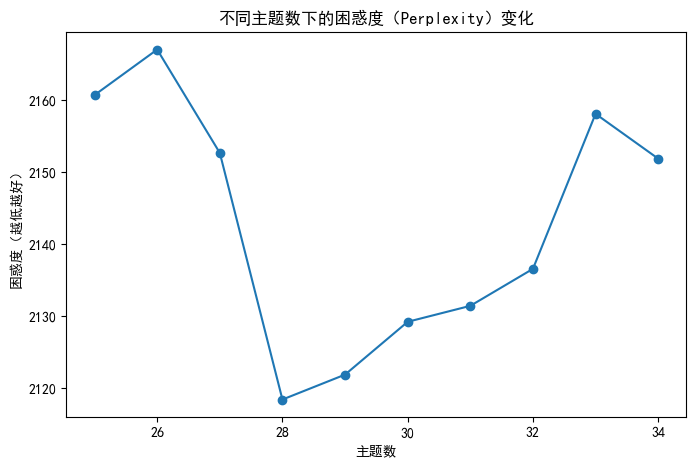

In [ ]:
# 困惑度检测找寻最佳主题数
docs = [" ".join(doc) for doc in texts_long_huazhong]  # 你的分词结果
vectorizer = CountVectorizer(max_df=0.95, min_df=5)
count_data = vectorizer.fit_transform(docs)

perplexities = []
topic_nums = range(25, 35)

for n in topic_nums:
    lda = LatentDirichletAllocation(
        n_components=n,
        max_iter=10,
        learning_method='batch',
        random_state=50
    )
    lda.fit(count_data)
    perplexity = lda.perplexity(count_data)
    perplexities.append(perplexity)
    print(f"主题数={n}, Perplexity={perplexity:.2f}")

# 绘制结果
plt.figure(figsize=(8, 5))
plt.plot(topic_nums, perplexities, marker='o')
plt.title("不同主题数下的困惑度（Perplexity）变化")
plt.xlabel("主题数")
plt.ylabel("困惑度（越低越好）")
plt.show()

In [56]:
lda_model_huazhong, count_matrix_huazhong, topics_df_huazhong = lda_from_long_texts(texts_long_huazhong, random_state=42, n_topics=28)

In [57]:
topics_df_huazhong

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28
0,神农顶,服务,预约,历史,文物,殷墟,文化,quot,表演,项目,...,洛阳,猕猴,索道,开封,动物,编钟,动物,东湖,学习,唐城
1,神农架,酒店,提前,感受,湖南省,遗址,历史,小镇,工作人员,动物,...,书院,云台山,张家界,总体,城市,曾侯乙,园区,磨山,文字,襄阳
2,大九湖,干净,携程,南阳,马王堆,内容,文物,电影,游客,宝泉,...,游客,南山,天子山,展厅,免费,湖北省博物馆,门票,风景区,相当,赞赞
3,神农,交通,时间,仿佛,博物院,丰富,展示,张家界,拍照,时间,...,国色,十分,袁家界,超赞,周口,勾践剑,野生动物,位于,了解,博园
4,天生桥,房间,门票,文化,长沙,文字,瓷器,国家森林公园,管理,游乐,...,大自然,巨巨,天梯,历史,玻璃,越王,小时,绿道,展馆,影视
5,官门山,热情,小时,医圣,展厅,展厅,洛阳,世界,进去,银基,...,不同,牧场,杨家,性价比,世界,文物,近距离,风景,发展,基地
6,天燕,天子,导游,故事,汉墓,曹操,艺术,长沙,晚上,王国,...,牡丹,世界,金鞭,有趣,火车,展厅,世界,面积,很大,拍摄
7,风景,设施,讲解,走进,陈列,甲骨文,青铜器,奇峰,收费,设施,...,位于,墓穴,画廊,建筑,游乐,馆之宝,野生,武汉市,历史,唐朝
8,自驾,驾六,工作人员,探秘,夫人,考古,博物院,华谊,小时,表演,...,李老师,很少,十里,长江,野生动物,湖北省,接触,amp,展品,大唐
9,木鱼,停车场,服务,魅力,历史,甲骨,丰富,兄弟,演出,刺激,...,活动,位于,黄石寨,清明上河图,剧场,化石,熊猫,休闲,安阳,时间


In [58]:
topics_df_huazhong.to_csv("./data/华中总结.csv", index=False, encoding='utf-8-sig')

##### 华南地区

In [26]:
huanan_comments = comments_df[comments_df['region'] == '华南地区']

In [27]:
texts_basic_huanan = prepare_texts_basic(df= huanan_comments, stopwords_path='./trip_stopwords.txt')

 已完成分词与过滤，共 70207 条有效评论


In [25]:
texts_long_huanan = filter_long_texts(texts_basic_huanan, min_len=20)

筛选完成，保留 14526 条长评论（长度 >= 20）


主题数=15, Perplexity=2532.15
主题数=16, Perplexity=2526.70
主题数=17, Perplexity=2528.95
主题数=18, Perplexity=2516.16
主题数=19, Perplexity=2486.72
主题数=20, Perplexity=2452.38
主题数=21, Perplexity=2561.77
主题数=22, Perplexity=2497.22
主题数=23, Perplexity=2503.01
主题数=24, Perplexity=2492.36
主题数=25, Perplexity=2547.91


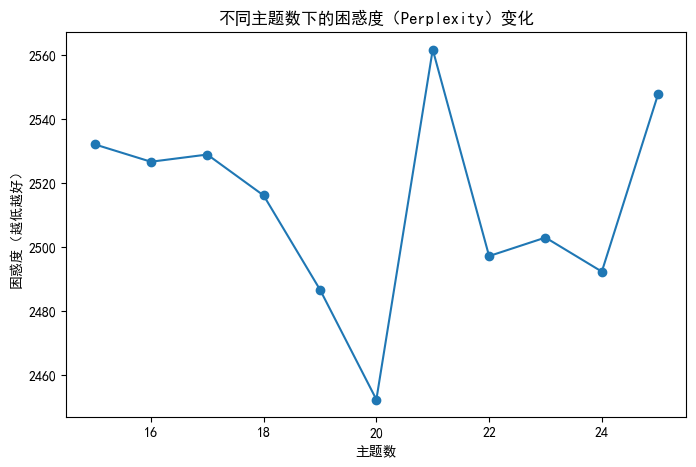

In [ ]:
# 困惑度检测找寻最佳主题数
docs = [" ".join(doc) for doc in texts_long_huanan]  # 你的分词结果
vectorizer = CountVectorizer(max_df=0.95, min_df=5)
count_data = vectorizer.fit_transform(docs)

perplexities = []
topic_nums = range(15, 26)

for n in topic_nums:
    lda = LatentDirichletAllocation(
        n_components=n,
        max_iter=10,
        learning_method='batch',
        random_state=42
    )
    lda.fit(count_data)
    perplexity = lda.perplexity(count_data)
    perplexities.append(perplexity)
    print(f"主题数={n}, Perplexity={perplexity:.2f}")

# 绘制结果
plt.figure(figsize=(8, 5))
plt.plot(topic_nums, perplexities, marker='o')
plt.title("不同主题数下的困惑度（Perplexity）变化")
plt.xlabel("主题数")
plt.ylabel("困惑度（越低越好）")
plt.show()

In [27]:
lda_model_huanan, count_matrix_huanan, topics_df_huanan = lda_from_long_texts(texts_long_huanan, random_state=42, n_topics=20)

In [28]:
topics_df_huanan

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20
0,动物,植物,文化,城市,广州,amp,工作人员,携程,拍照,广东省,猴子,门票,科学,建筑,深圳,讲解,鳄鱼,老街,演出,植物
1,长隆,世界,历史,恐龙,中山大学,红树林,小时,咖啡,时间,位于,小时,项目,电影,陈家祠,梧桐山,植物,日本,建筑,红色,热带
2,火车,野生动物,建筑,化石,不錯,世界,设施,免费,小时,珠江,缆车,海龟,中心,装饰,苏铁,项目,鸟类,北海,娘子军,酒店
3,园区,位于,展示,去年,位于,位于,时间,门票,门票,学习,门票,展品,科普,陈氏,兰花,祖庙,中山,历史,震撼,游客
4,表演,园区,广州,旅行,校园,丹霞山,过去,提前,晚上,历史,工作人员,南海,槟榔,祠堂,植物,讲解员,孙中山,骑楼,三亚,自然
5,熊猫,国家,展览,风景,广州市,猕猴,进去,预约,满意,展馆,猴岛,二楼,科技,书院,仙湖,表演,门票,特色,演员,独特
6,缆车,华南,文物,去过,大学城,保护,门口,服务,园区,铜鼓,时间,一楼,黎族,岭南,园内,知识,故居,街道,舞台,丰富
7,乐园,长鹿,艺术,好奇,交通,丹霞地貌,游客,购票,分钟,了解,进去,展馆,主题,艺术,广州,佛山,基地,百年,实景,感受
8,野生,游客,岭南,心情,校区,自然,过来,现场,表演,很大,索道,展厅,互动,砖雕,位于,导游,环境,变成,表演,科普
9,世界,特色,位于,想要,铁路,岛上,项目,购买,电瓶车,自然,风景,时间,文化,木雕,品种,可可,免费,全是,移动,设施


##### 西北地区

In [29]:
xibei_comments = comments_df[comments_df['region'] == '西北地区']

In [30]:
texts_basic_xibei = prepare_texts_basic(df= xibei_comments, stopwords_path='./trip_stopwords.txt')

 已完成分词与过滤，共 63361 条有效评论


In [31]:
texts_long_xibei = filter_long_texts(texts_basic_xibei, min_len=20)

筛选完成，保留 16945 条长评论（长度 >= 20）


主题数=23, Perplexity=2323.97
主题数=24, Perplexity=2333.45
主题数=25, Perplexity=2314.37
主题数=26, Perplexity=2326.66


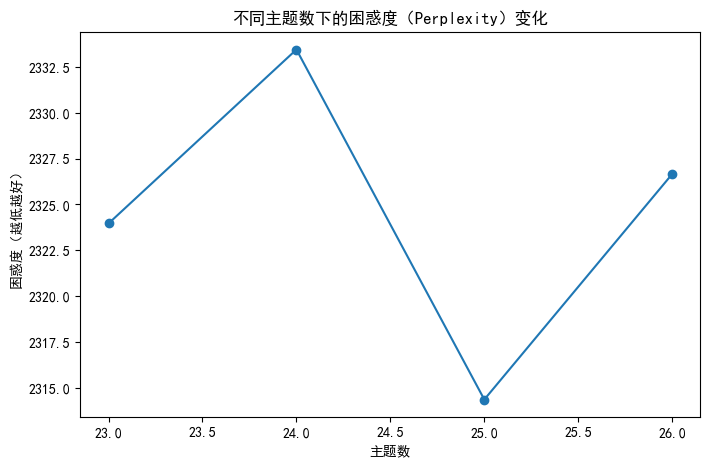

In [ ]:
# 困惑度检测找寻最佳主题数
docs = [" ".join(doc) for doc in texts_long_xibei]  # 你的分词结果
vectorizer = CountVectorizer(max_df=0.95, min_df=5)
count_data = vectorizer.fit_transform(docs)

perplexities = []
topic_nums = range(23, 27)

for n in topic_nums:
    lda = LatentDirichletAllocation(
        n_components=n,
        max_iter=10,
        learning_method='batch',
        random_state=50
    )
    lda.fit(count_data)
    perplexity = lda.perplexity(count_data)
    perplexities.append(perplexity)
    print(f"主题数={n}, Perplexity={perplexity:.2f}")

# 绘制结果
plt.figure(figsize=(8, 5))
plt.plot(topic_nums, perplexities, marker='o')
plt.title("不同主题数下的困惑度（Perplexity）变化")
plt.xlabel("主题数")
plt.ylabel("困惑度（越低越好）")
plt.show()

In [40]:
lda_model_xibei, count_matrix_xibei, topics_df_xibei = lda_from_long_texts(texts_long_xibei, random_state=42, n_topics=25)

In [42]:
topics_df_xibei.to_csv("./data/西北总结.csv", index=False, encoding='utf-8-sig')

##### 西南地区

In [44]:
xinan_comments = comments_df[comments_df['region'] == '西南地区']

In [45]:
texts_basic_xinan = prepare_texts_basic(df= xinan_comments, stopwords_path='./trip_stopwords.txt')

 已完成分词与过滤，共 100255 条有效评论


In [46]:
texts_long_xinan = filter_long_texts(texts_basic_xinan, min_len=20)

筛选完成，保留 24477 条长评论（长度 >= 20）


主题数=20, Perplexity=3190.58
主题数=21, Perplexity=3154.73
主题数=22, Perplexity=3182.16
主题数=23, Perplexity=3169.69
主题数=24, Perplexity=3140.77
主题数=25, Perplexity=3164.21
主题数=26, Perplexity=3139.23
主题数=27, Perplexity=3159.34
主题数=28, Perplexity=3206.62
主题数=29, Perplexity=3158.33
主题数=30, Perplexity=3204.44


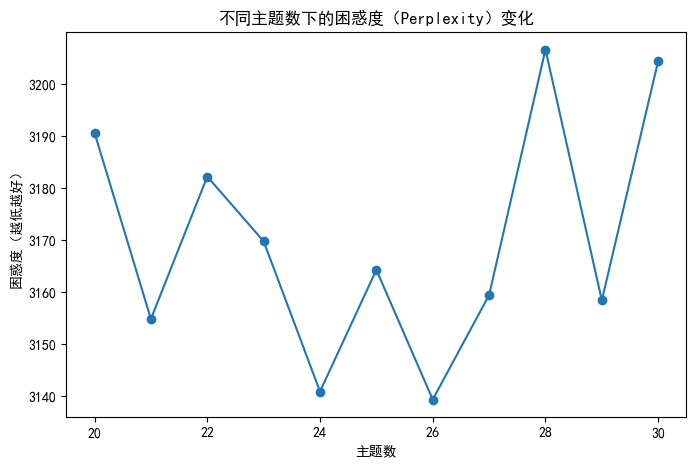

In [ ]:
# 困惑度检测找寻最佳主题数
docs = [" ".join(doc) for doc in texts_long_xinan]  # 你的分词结果
vectorizer = CountVectorizer(max_df=0.95, min_df=5)
count_data = vectorizer.fit_transform(docs)

perplexities = []
topic_nums = range(20, 31)

for n in topic_nums:
    lda = LatentDirichletAllocation(
        n_components=n,
        max_iter=10,
        learning_method='batch',
        random_state=42
    )
    lda.fit(count_data)
    perplexity = lda.perplexity(count_data)
    perplexities.append(perplexity)
    print(f"主题数={n}, Perplexity={perplexity:.2f}")

# 绘制结果
plt.figure(figsize=(8, 5))
plt.plot(topic_nums, perplexities, marker='o')
plt.title("不同主题数下的困惑度（Perplexity）变化")
plt.xlabel("主题数")
plt.ylabel("困惑度（越低越好）")
plt.show()

In [48]:
lda_model_xinan, count_matrix_xinan, topics_df_xinan = lda_from_long_texts(texts_long_xinan, random_state=42, n_topics=26)

In [50]:
topics_df_xinan.to_csv("./data/西南总结.csv", index=False, encoding='utf-8-sig')